In [1]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import folium
import json
from ipywidgets import IntSlider, interact
from scipy import stats


In [2]:
# do that: conda install -c conda-forge umap-learn
import umap

In [3]:
#reading the FAO data set
fertilizer_area=pd.read_csv('./data/Environment_Fertilizers_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
crops=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')

## looking at nan values


In [4]:
crops[crops.Value.isnull()]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
128,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,1961,1961,ha,NaN,M
129,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,1962,1962,ha,NaN,M
130,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,1963,1963,ha,NaN,M
131,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,1964,1964,ha,NaN,M
132,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,1965,1965,ha,NaN,M
...,...,...,...,...,...,...,...,...,...,...,...
2421505,5817,Net Food Importing Developing Countries,97,Triticale,5510,Production,1983,1983,tonnes,NaN,A
2421506,5817,Net Food Importing Developing Countries,97,Triticale,5510,Production,1984,1984,tonnes,NaN,A
2421507,5817,Net Food Importing Developing Countries,97,Triticale,5510,Production,1985,1985,tonnes,NaN,A
2421508,5817,Net Food Importing Developing Countries,97,Triticale,5510,Production,1986,1986,tonnes,NaN,A


In [5]:
fertilizer_area[fertilizer_area.Value.isnull()]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag


Is there really no value missing or is it equal to zero when it's missing ?

In [6]:
fertilizer_area.query('Value==0').query('`Item Code`==3104').head(10)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
25,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2013,2013,kg/ha,0.0,Fc
26,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2014,2014,kg/ha,0.0,Fc
27,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2015,2015,kg/ha,0.0,Fc
28,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2016,2016,kg/ha,0.0,Fc
59,3,Albania,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2002,2002,kg/ha,0.0,Fc
60,3,Albania,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2003,2003,kg/ha,0.0,Fc
281,1,Armenia,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2002,2002,kg/ha,0.0,Fc
288,1,Armenia,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2009,2009,kg/ha,0.0,Fc
703,53,Benin,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2004,2004,kg/ha,0.0,Fc
705,53,Benin,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2006,2006,kg/ha,0.0,Fc


As we see, country as Afghanistan have 0 value for 4 last years, is it true everywhere ?

In [7]:
fertilizer_area.query('Area == "Afghanistan"').query('`Item Code`==3104')

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
25,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2013,2013,kg/ha,0.0,Fc
26,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2014,2014,kg/ha,0.0,Fc
27,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2015,2015,kg/ha,0.0,Fc
28,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2016,2016,kg/ha,0.0,Fc


#### Need further investigation

### Actions
3 differents possibles methods to deal with it:

2 first can be selected in umap(year) function
* replacing nan value by 0
* replacing nan value by mean

Last one executed at the end
* dropping all nan value

### looking at each type of fertilizer (and associated code)

In [8]:
#looking at each type of fertilizer (and associated code)
ferti_items = pd.DataFrame({'Item':fertilizer_area['Item'].unique(), 'Item Code':fertilizer_area['Item Code'].unique()})
ferti_items

,Item,Item Code
0,Nutrient nitrogen N (total),3102
1,Nutrient phosphate P2O5 (total),3103
2,Nutrient potash K2O (total),3104


In [9]:
ferti_items.Item[ferti_items['Item Code']==3102]

0    Nutrient nitrogen N (total)
Name: Item, dtype: object

## Important functions:

In [10]:
def ferti_class(x, L): #associate a color to each bin of fertilizer
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

In [11]:
# Creation of a function doing the umap (works also for only 1 dimension end)
from sklearn import preprocessing
def umap_year(year, ferti_code, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .pivot(index='Area',columns='Item',values='Value')
            #.fillna(value=0) # decomment this and comment point 2 to get nan value replaced by 0
            .reset_index()
              )
    yield_for_merge.fillna(yield_for_merge.mean(), inplace = True) # point 2
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 
    
    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    umap_fertilizer=(fertilizer_area
                    .query('Year == @year')
                    .query('`Area Code` <300')
                    .query('`Item Code` == @ferti_code')
                    .loc[:,['Area','Value']]
                    )
    embedding2=pd.merge(embedding2,umap_fertilizer,left_on='Area',right_on='Area')
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2['Value']=(embedding2['Value']-min(embedding2['Value']))/(max(embedding2['Value'])-min(embedding2['Value']))
    embedding2['ferti_class']=embedding2.Value.apply(lambda x: ferti_class(x, embedding2.Value))
    
    coef = np.polyfit(embedding2[0],embedding2.Value,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

## plot ferti vs umap for multiples years


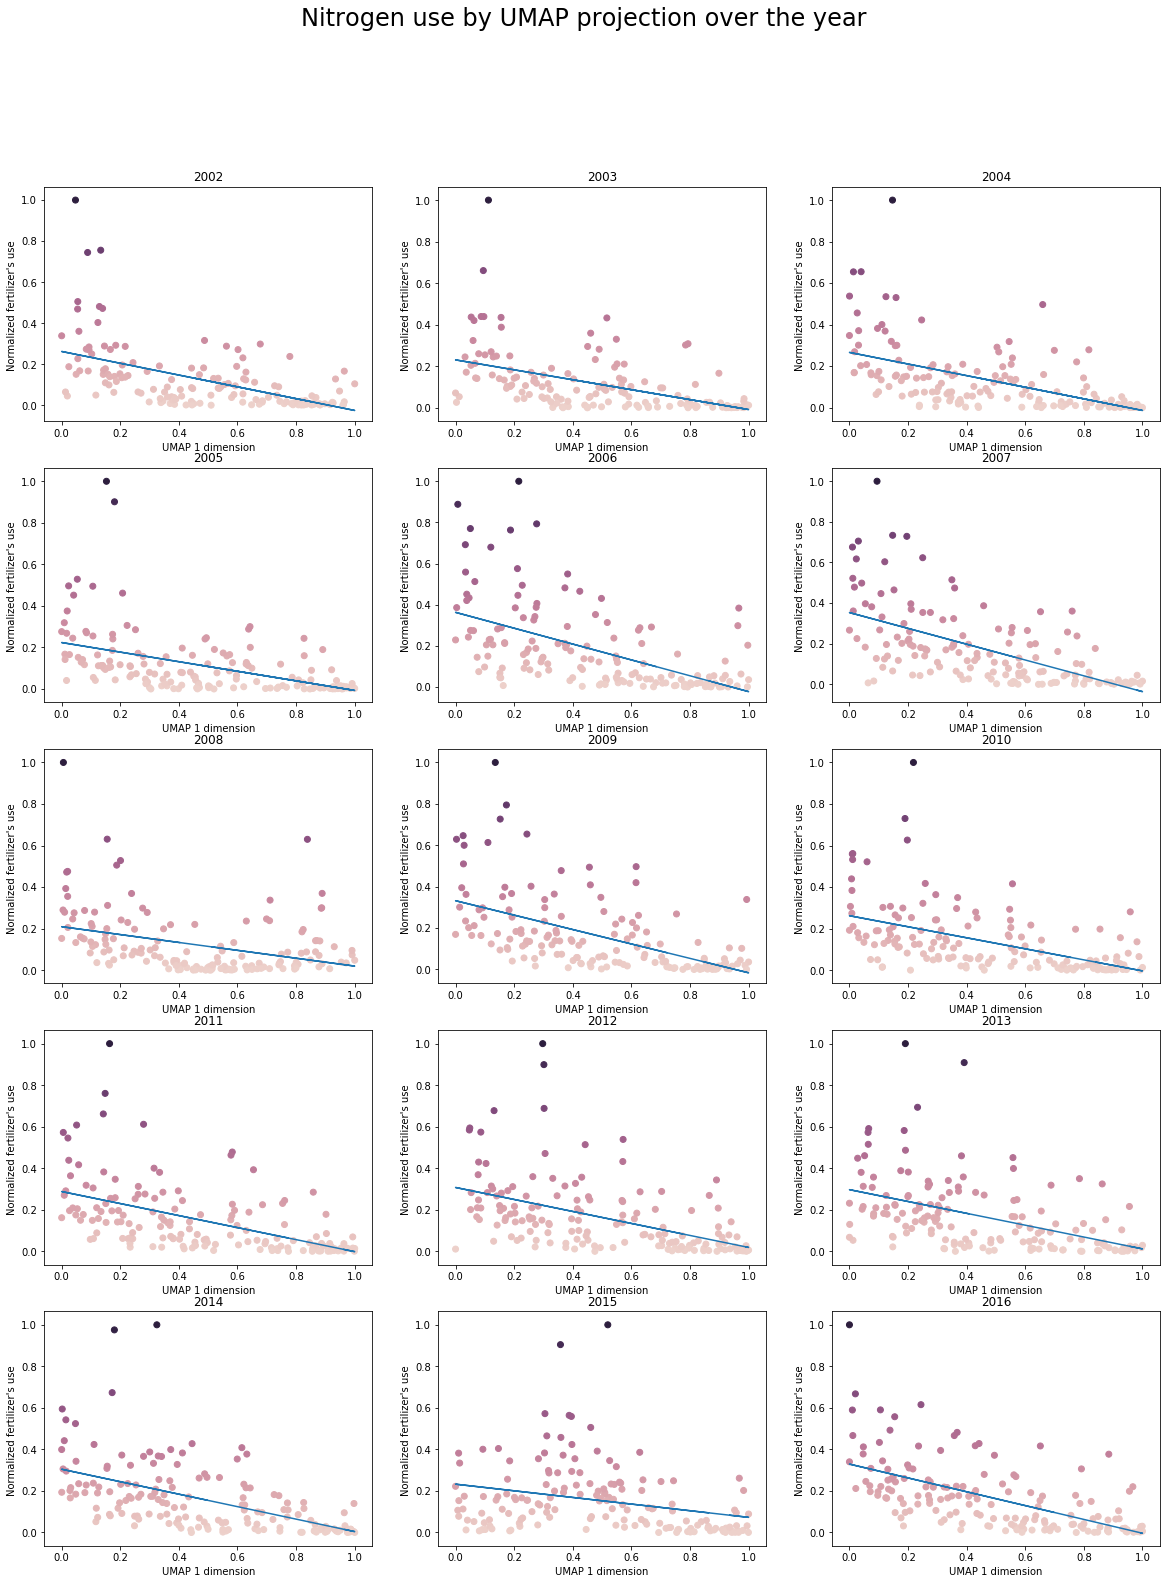

In [12]:
#plot for multiple years for Nutrient nitrogen N vs umap
year=fertilizer_area['Year Code'].unique()
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Nitrogen use by UMAP projection over the year', fontsize=24)
for x in range (n) : 
    vis_2016=umap_year(year[x], 3102, 1)
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    embedding2=vis_2016[1] 
    coef = vis_2016[2]
    poly1d_fn = np.poly1d(coef)
    clarity_ranking = embedding2.Value

    cmap = sns.cubehelix_palette(as_cmap=True)
    plt.scatter(embedding2[0], embedding2.Value,c=clarity_ranking, cmap=cmap)
    plt.plot(embedding2[0], poly1d_fn(embedding2[0]))
    plt.title('%d'%year[x]);
    plt.xlabel("UMAP 1 dimension")
    plt.ylabel("Normalized fertilizer's use ")

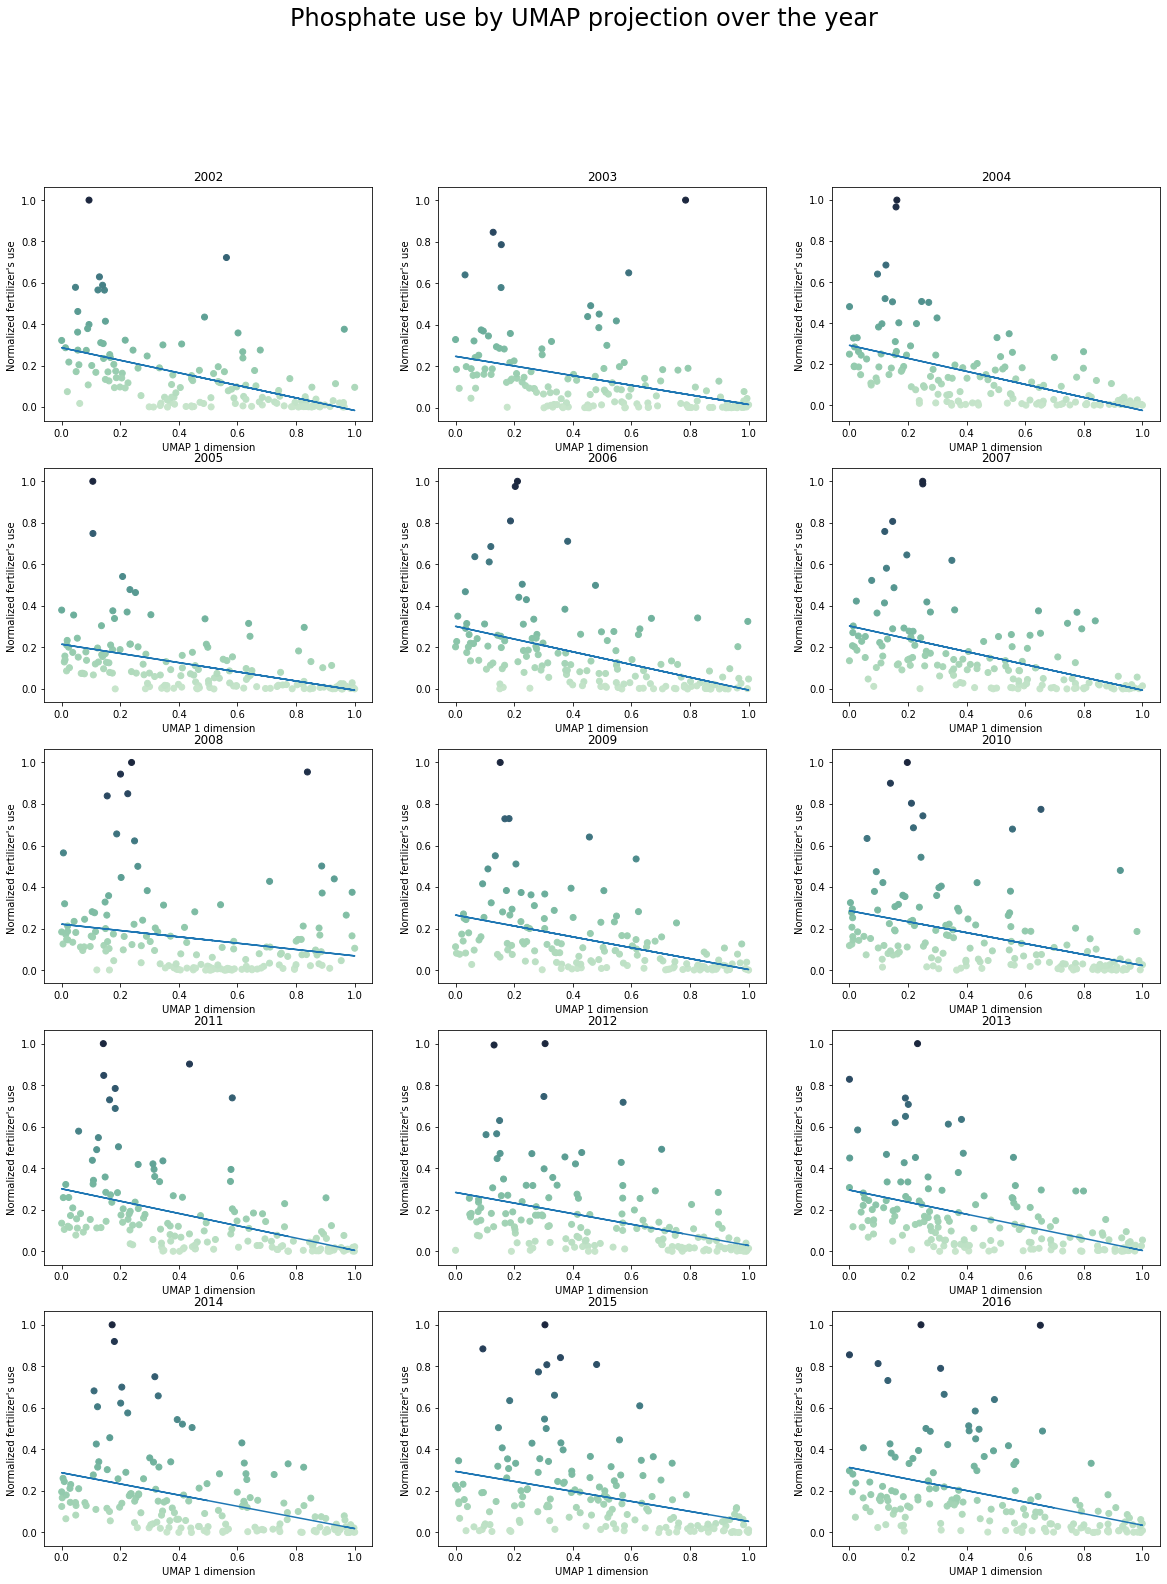

In [13]:
#plot for multiple years for Nutrient phosphate P2O5 vs umap
year=fertilizer_area['Year Code'].unique()
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Phosphate use by UMAP projection over the year', fontsize=24)
for x in range (n) : 
    vis_2016=umap_year(year[x], 3103, 1)
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    embedding2=vis_2016[1] 
    coef = vis_2016[2]
    poly1d_fn = np.poly1d(coef)
    clarity_ranking = embedding2.Value

    cmap = sns.cubehelix_palette(as_cmap=True,rot=-.4)
    plt.scatter(embedding2[0], embedding2.Value,c=clarity_ranking, cmap=cmap)
    plt.plot(embedding2[0], poly1d_fn(embedding2[0]))
    plt.title('%d'%year[x]);
    plt.xlabel("UMAP 1 dimension")
    plt.ylabel("Normalized fertilizer's use ")

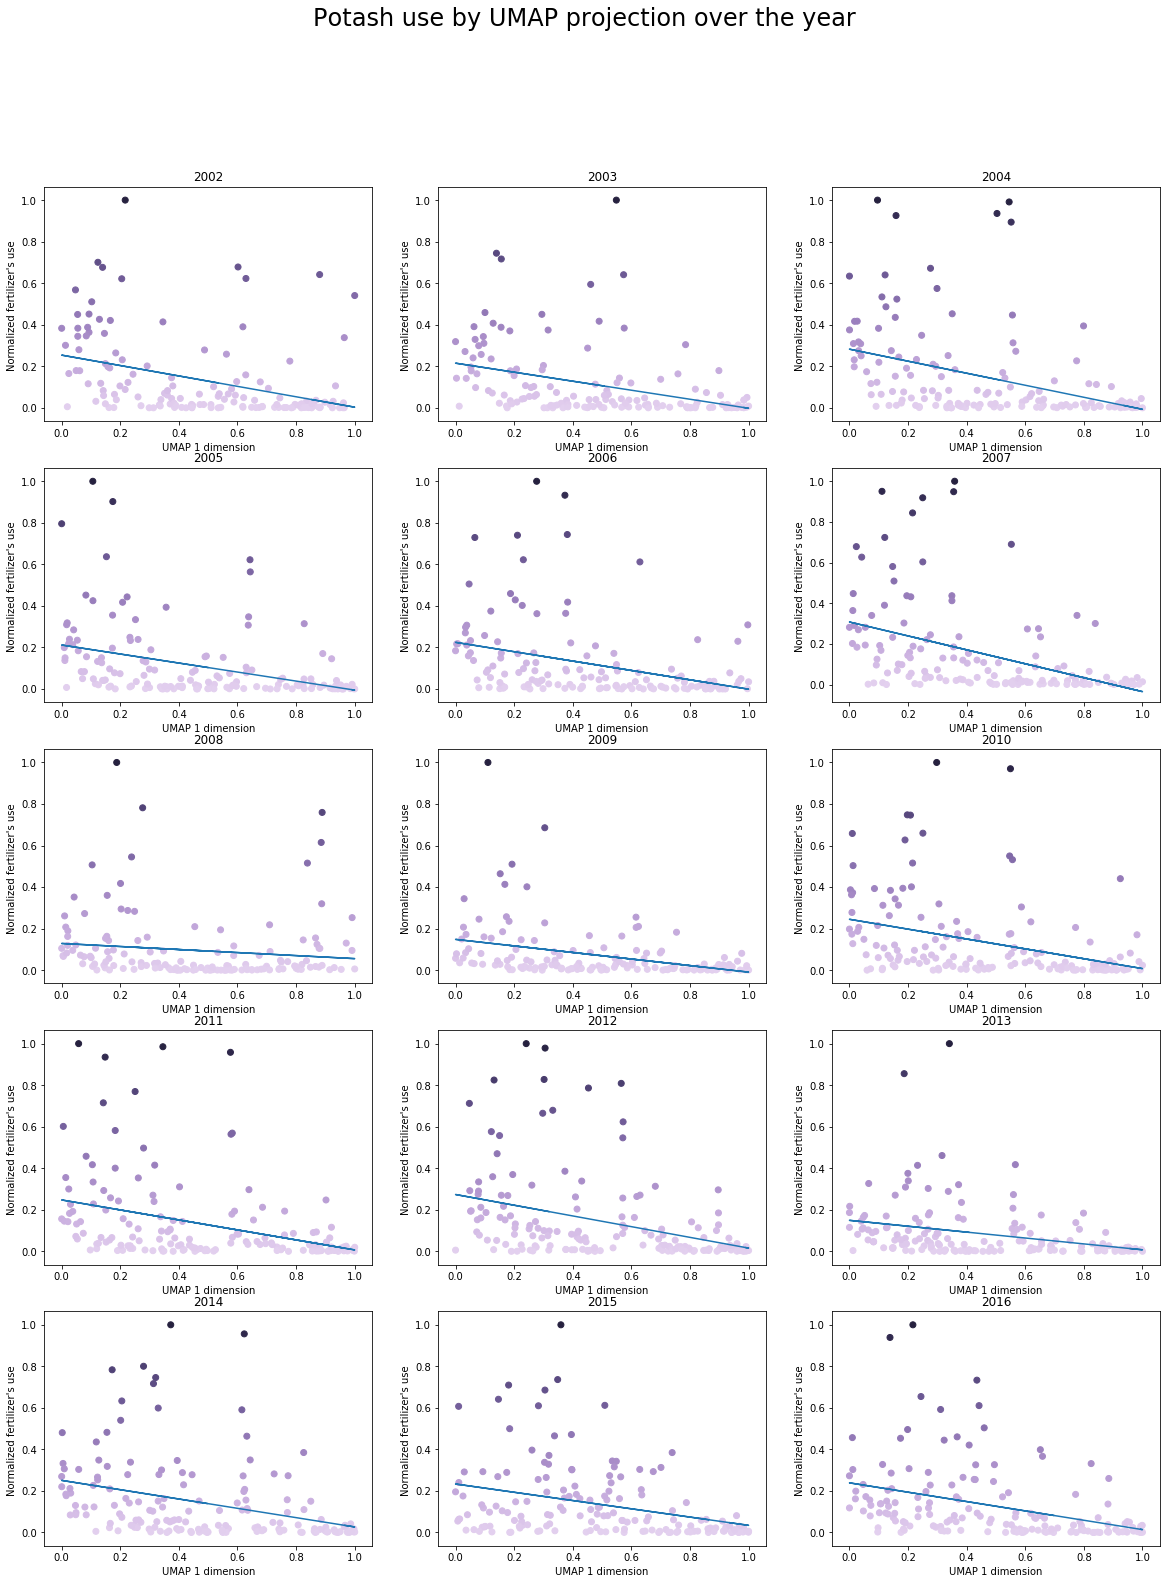

In [14]:
#plot for multiple years for Nutrient potash K2O vs umap
year=fertilizer_area['Year Code'].unique()
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Potash use by UMAP projection over the year', fontsize=24)
for x in range (n) : 
    vis_2016=umap_year(year[x], 3104, 1)
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    embedding2=vis_2016[1] 
    coef = vis_2016[2]
    poly1d_fn = np.poly1d(coef)
    clarity_ranking = embedding2.Value

    cmap = sns.cubehelix_palette(as_cmap=True,rot=.1)
    plt.scatter(embedding2[0], embedding2.Value,c=clarity_ranking, cmap=cmap)
    plt.plot(embedding2[0], poly1d_fn(embedding2[0]))
    plt.title('%d'%year[x]);
    plt.xlabel("UMAP 1 dimension")
    plt.ylabel("Normalized fertilizer's use ")

### Comment of the plots above
For year 2016, umap axis seems to be inversed because of the position of high fertilizers use which is on the right (while there are on the left on all other plots).
In addition, from on year to another, fertilizer's repartition can change totaly (e.g potash between 2012 and 2013) and it has a great impact on linear interpolation slope (it can be seen on the coefficient plot hereafter)


LinregressResult(slope=0.0008989474735867415, intercept=-2.0907501939792765, rvalue=0.06260988897248433, pvalue=0.82457349226105, stderr=0.003974356464325076)
LinregressResult(slope=0.0005446587961671456, intercept=-1.3608212064507428, rvalue=0.05643115406423261, pvalue=0.8416729804095865, stderr=0.0026726452079854726)
LinregressResult(slope=0.003058682478043304, intercept=-6.364848374099066, rvalue=0.21804582556296137, pvalue=0.43498524590261967, stderr=0.0037969721134233007)


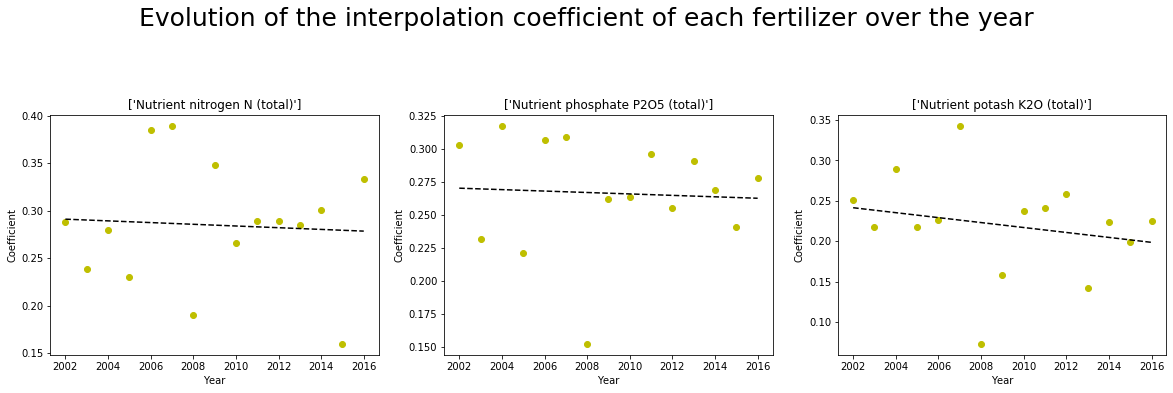

In [15]:
# umap for all years available in the fertilizer dataset (the more restrictive dataset)

fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)
for x in range(3):
    mean=[]
    for year in fertilizer_area.pivot_table(index=['Year Code']).index :
        adding=umap_year(year,3102+x,1)
        mean.append([adding[0],adding[2][0]])
    mean=pd.DataFrame(mean)
    print(stats.linregress(mean[0],mean[1]))
    # look at coef over the years
    ax1 = fig.add_subplot(3,3,x+1)
    coef = np.polyfit(mean[0],abs(mean[1]),1) #test regression dim 1 ...
    poly1d_fn = np.poly1d(coef)
    plt.plot(mean[0],abs(mean[1]), 'yo',mean[0], poly1d_fn(mean[0]), '--k')
    
    plt.xlabel('Year')
    plt.ylabel('Coefficient')
    fertilizer=ferti_items.Item[ferti_items['Item Code']==3102+x].values
    plt.title('%s'%fertilizer)

### Comment with nan replaced by 0 
for each fertilizer, we can see the absolute value of slope coefficient is decreasing over the years. As this coefficient capture relation between fertilizer use and agriculture efficiency (projected in one dimension using umap). We might think of a loss of efficiency of each fertilizer over the year.
However interpolation error seems quite high 

### Comment with nan replaced by mean 

To be done

## Dropping nan values


In [16]:
def umap_year(year, ferti_code, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .pivot(index='Area',columns='Item',values='Value')
            #.fillna(value=0) # decomment this and comment point 2 to get nan value replaced by 0
            .reset_index()
            .dropna(axis=0)
              )
    #yield_for_merge.fillna(yield_for_merge.mean(), inplace = True) # point 2
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 
    
    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    umap_fertilizer=(fertilizer_area
                    .query('Year == @year')
                    .query('`Area Code` <300')
                    .query('`Item Code` == @ferti_code')
                    .loc[:,['Area','Value']]
                    )
    embedding2=pd.merge(embedding2,umap_fertilizer,left_on='Area',right_on='Area')
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2['Value']=(embedding2['Value']-min(embedding2['Value']))/(max(embedding2['Value'])-min(embedding2['Value']))
    embedding2['ferti_class']=embedding2.Value.apply(lambda x: ferti_class(x, embedding2.Value))
    
    coef = np.polyfit(embedding2[0],embedding2.Value,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

LinregressResult(slope=0.0019224488820394035, intercept=-3.9203969947226023, rvalue=0.06756692424627826, pvalue=0.8109073952192128, stderr=0.007873273991151048)
LinregressResult(slope=0.009467758527038864, intercept=-19.13866581152456, rvalue=0.2211919452185695, pvalue=0.42822033450375996, stderr=0.011577462195664271)
LinregressResult(slope=-0.009226719437906023, intercept=18.473879186382945, rvalue=-0.23915714542253394, pvalue=0.3906416995908396, stderr=0.010389698710557518)


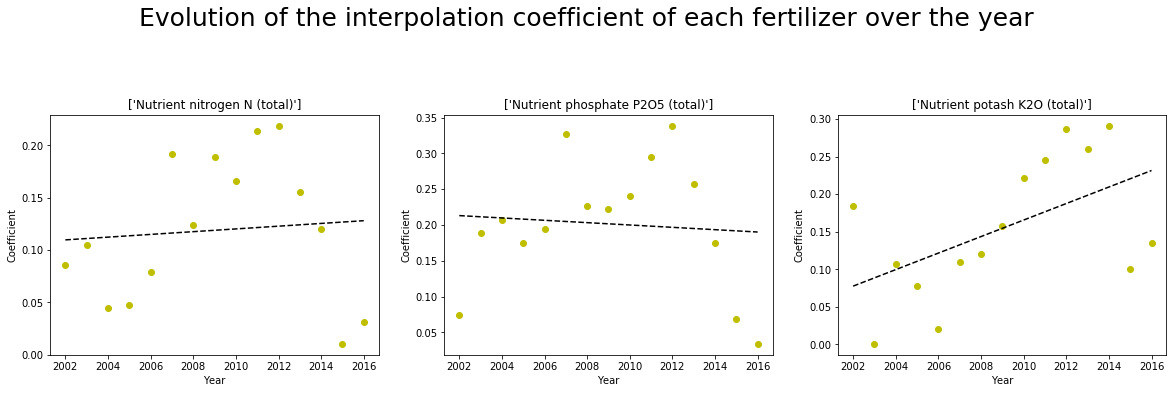

In [17]:
fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)
for x in range(3):
    mean=[]
    for year in fertilizer_area.pivot_table(index=['Year Code']).index :
        adding=umap_year(year,3102+x,1)
        mean.append([adding[0],adding[2][0]])
    mean=pd.DataFrame(mean)
    print(stats.linregress(mean[0],mean[1]))
    # look at coef over the years
    ax1 = fig.add_subplot(3,3,x+1)
    coef = np.polyfit(mean[0],abs(mean[1]),1) #test regression dim 1 ...
    poly1d_fn = np.poly1d(coef)
    plt.plot(mean[0],abs(mean[1]), 'yo',mean[0], poly1d_fn(mean[0]), '--k')
    
    plt.xlabel('Year')
    plt.ylabel('Coefficient')
    fertilizer=ferti_items.Item[ferti_items['Item Code']==3102+x].values
    plt.title('%s'%fertilizer)

## Comments : 
Plot 1 and 2 could be polynomial interpolation
More researches have to be done to explain this curves :

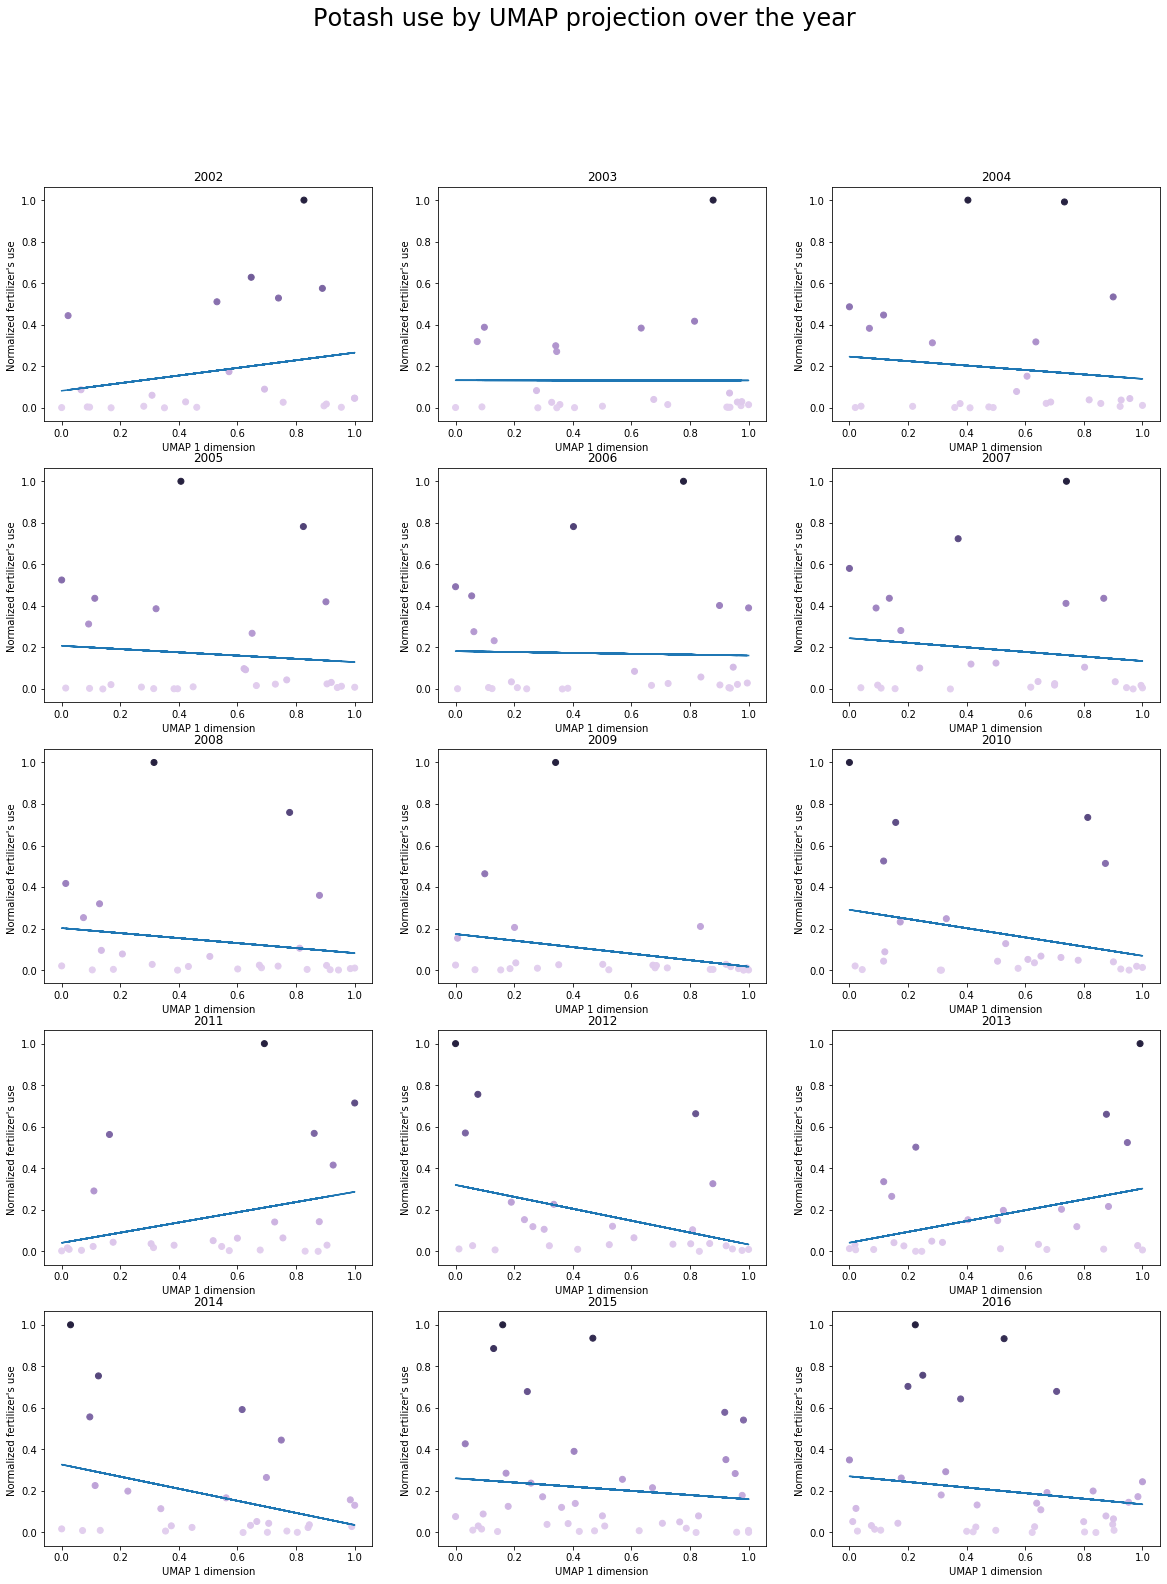

In [18]:
#plot for multiple years for Nutrient potash K2O vs umap
year=fertilizer_area['Year Code'].unique()
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Potash use by UMAP projection over the year', fontsize=24)
for x in range (n) : 
    vis_2016=umap_year(year[x], 3104, 1)
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    embedding2=vis_2016[1] 
    coef = vis_2016[2]
    poly1d_fn = np.poly1d(coef)
    clarity_ranking = embedding2.Value

    cmap = sns.cubehelix_palette(as_cmap=True,rot=.1)
    plt.scatter(embedding2[0], embedding2.Value,c=clarity_ranking, cmap=cmap)
    plt.plot(embedding2[0], poly1d_fn(embedding2[0]))
    plt.title('%d'%year[x]);
    plt.xlabel("UMAP 1 dimension")
    plt.ylabel("Normalized fertilizer's use ")

## Comments :
Umap constantly interchanged

Fertilizer are 0 very often ( it's maybe just missing informations ...)

## Analysis precautions :
We should keep in mind our fertilizer dataset year range as it's relatively small (14 years overall) when we are drawing conclusion.